Cell 1 – Setup imports + project root

In [ ]:
# 02_embeddings_clustering.ipynb

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import load_config
from src.data.loader import load_jobs
from src.embeddings.embedder import embed_texts, build_and_save_embeddings
from src.evaluation.metrics import internal_cluster_metrics
from src.clustering.clustering import kmeans_clusters, hdbscan_clusters, agglomerative_clusters
from src.data.preprocess import build_embed_text
from sentence_transformers import SentenceTransformer


sns.set(style="whitegrid")

cfg = load_config()
TEXT_COL = cfg["jobs"]["text_column"]

LABELS_PATH = PROJECT_ROOT / "results" / "clusters" / "kmeans_labels.npy"
CLEAN_VERSION = "boiler_v1_len50_cap3000"
EMB_PATH = PROJECT_ROOT / "results" / "embeddings" / f"embeddings_{CLEAN_VERSION}.npy"
JOBS_PATH = PROJECT_ROOT / "results" / "embeddings" / f"jobs_{CLEAN_VERSION}.parquet"


cfg


In [ ]:
print("Using EMB_PATH =", EMB_PATH.resolve())


Cell 2 – Load jobs & build embeddings (or reuse cached)

In [ ]:
jobs = load_jobs()
print("Jobs shape:", jobs.shape)



mask = clean_texts.str.len() > 50
jobs = jobs.loc[mask].reset_index(drop=True)
texts = clean_texts.loc[mask].tolist()

print("After filtering:", jobs.shape)





In [27]:
# Cell 2 — Rebuild preprocessing + embeddings + kmeans labels (ALWAYS rebuild, then save)

from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# =========================
# 0) Paths / versioning
# =========================
CLEAN_VERSION = "boiler_v1_len50_cap3000"

EMB_PATH   = PROJECT_ROOT / "results" / "embeddings" / f"embeddings_{CLEAN_VERSION}.npy"
JOBS_PATH  = PROJECT_ROOT / "results" / "embeddings" / f"jobs_{CLEAN_VERSION}.parquet"
LABELS_PATH = PROJECT_ROOT / "results" / "clusters" / "kmeans_labels.npy"  # 요청한 경로 그대로

EMB_PATH.parent.mkdir(parents=True, exist_ok=True)
JOBS_PATH.parent.mkdir(parents=True, exist_ok=True)
LABELS_PATH.parent.mkdir(parents=True, exist_ok=True)

# =========================
# 1) Load jobs
# =========================
TEXT_COL = "description"   # config 기준
jobs_raw = load_jobs()
print("Jobs shape (raw):", jobs_raw.shape)
assert TEXT_COL in jobs_raw.columns, f"Missing column: {TEXT_COL}"

# =========================
# 2) Boilerplate cleaning
# =========================
def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = (s.replace("â€™", "'")
           .replace("â€œ", '"')
           .replace("â€", '"')
           .replace("â€“", "-")
           .replace("â€”", "-"))
    s = re.sub(r"\s+", " ", s).strip()
    return s

SECTION_START = re.compile(
    r"\b(responsibilities|what you(?:'| a)?ll do|duties|role|job description|requirements|qualifications|what we(?:'| a)?re looking for|skills|experience)\b",
    flags=re.IGNORECASE
)
SECTION_END = re.compile(
    r"\b(equal opportunity|eeo|diversity|accommodation|reasonable accommodation|background check|drug test|right to work|i-9|privacy|disclaimer|terms of employment)\b",
    flags=re.IGNORECASE
)

def keep_job_sections(text: str, min_chars: int = 400) -> str:
    t = normalize_text(text)
    m = SECTION_START.search(t)
    if not m:
        return t
    tail = t[m.start():]
    e = SECTION_END.search(tail)
    cut = tail[:e.start()] if e else tail
    cut = cut.strip()
    return cut if len(cut) >= min_chars else t

BOILER_PATTERNS = [
    r"\bequal opportunity employer\b.*",
    r"\beeo\b.*",
    r"\bwe are an equal opportunity\b.*",
    r"\bdiversity\b.*\binclusion\b.*",
    r"\breasonable accommodation\b.*",
    r"\baccommodation\b.*\bdisability\b.*",
    r"\bbackground check\b.*",
    r"\bdrug test\b.*",
    r"\b401k\b.*",
    r"\bhealth insurance\b.*",
    r"\bdental\b.*\bvision\b.*",
    r"\bbenefits\b.*",
    r"\babout (us|the company)\b.*",
    r"\bcompany overview\b.*",
    r"\bour mission\b.*",
    r"\bwho we are\b.*",
    r"\bprivacy policy\b.*",
    r"\bdisclaimer\b.*",
]
BOILER_REGEX = re.compile("|".join(f"(?:{p})" for p in BOILER_PATTERNS), flags=re.IGNORECASE)

def remove_boilerplate(text: str) -> str:
    t = normalize_text(text)
    t = BOILER_REGEX.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def clean_job_text(text: str) -> str:
    t = keep_job_sections(text)
    t = remove_boilerplate(t)
    t = t[:3000]   # cap3000
    return t

jobs_clean = jobs_raw.copy()
jobs_clean[TEXT_COL] = jobs_clean[TEXT_COL].astype(str).map(clean_job_text)

# 빈 텍스트 방지: 비면 원문으로 되돌림(데이터 손실 최소화)
empty_mask = jobs_clean[TEXT_COL].astype(str).str.strip().eq("")
print("Empty after cleaning:", int(empty_mask.sum()))
jobs_clean.loc[empty_mask, TEXT_COL] = jobs_raw.loc[empty_mask, TEXT_COL].astype(str)

# 너무 짧으면 제외 (len50)
MIN_LEN = 50
mask = jobs_clean[TEXT_COL].astype(str).str.len() > MIN_LEN
jobs_clean = jobs_clean.loc[mask].reset_index(drop=True)

texts = jobs_clean[TEXT_COL].astype(str).tolist()

print("Jobs shape (clean+filtered):", jobs_clean.shape)
print("Sample cleaned text:\n", texts[0][:400])

# =========================
# 3) Embeddings (ALWAYS rebuild) + Save
# =========================
# 옵션 A: 프로젝트에 이미 build_and_save_embeddings(jobs, path, texts=...)가 있으면 사용
# embeddings = build_and_save_embeddings(jobs_clean, EMB_PATH, texts=texts)

# 옵션 B: 만약 위 함수가 없거나 texts를 무시하면 아래처럼 직접 생성하는 버전으로 교체 가능.
# (여기서는 A가 있다고 가정)

embeddings = build_and_save_embeddings(jobs_clean, EMB_PATH, texts=texts)
print("Embeddings shape:", embeddings.shape)

# 안전 체크
assert embeddings.shape[0] == len(jobs_clean), "Embeddings rows != jobs_clean rows"

# jobs_clean도 저장 (나중에 join 꼬임 방지)
jobs_clean.to_parquet(JOBS_PATH, index=False)
print("✅ Saved jobs_clean to:", JOBS_PATH)

# =========================
# 4) KMeans labels (ALWAYS rebuild) + Save
# =========================
# config에서 n_clusters를 쓰고 있으면 그걸로 바꾸면 됨.
N_CLUSTERS = 100  # 너 노트북 metrics에 100으로 찍혀있었음

km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
km_labels = km.fit_predict(embeddings)

np.save(LABELS_PATH, km_labels)
print("✅ Saved kmeans labels to:", LABELS_PATH)
print("Labels shape:", km_labels.shape)

# =========================
# 5) Convenience outputs for downstream cells
# =========================
jobs = jobs_clean              # 이후 셀들이 jobs를 쓰면 깨끗한 데이터로 연결
print("\nDone. Using cleaned jobs + rebuilt embeddings + rebuilt labels.")


Jobs shape (raw): (24164, 15)
Empty after cleaning: 219
Jobs shape (clean+filtered): (23838, 15)
Sample cleaned text:
 At IBM, we do more than work. We create. We create as technologists, developers, and engineers. We create with our partners. We create with our competitors. If you're searching for ways to make the world work better through technology and infrastructure, software and consulting, then we want to work with you. We're here to help every creator turn their "what if" into what is. Let's create somethin


Batches: 100%|██████████| 373/373 [15:24<00:00,  2.48s/it]


Embeddings shape: (23838, 384)
✅ Saved jobs_clean to: C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\jobs_boiler_v1_len50_cap3000.parquet
✅ Saved kmeans labels to: C:\Users\hisuk\labor-market-nlp-prototype\results\clusters\kmeans_labels.npy
Labels shape: (23838,)

Done. Using cleaned jobs + rebuilt embeddings + rebuilt labels.


Number of clusters: 100


cluster  speciality_clean    
0        Unknown                 49
         Consulting               9
         IT Consulting            9
1        Unknown                 33
         Packaging                3
                                 ..
98       Insurance               19
         Life Insurance           8
99       Unknown                 73
         IT Staffing              7
         Software Development     7
Name: count, Length: 300, dtype: int64

0    280
1    164
2    247
3    271
4    157
5    278
6    272
7    395
8    270
9    460
Name: count, dtype: int64

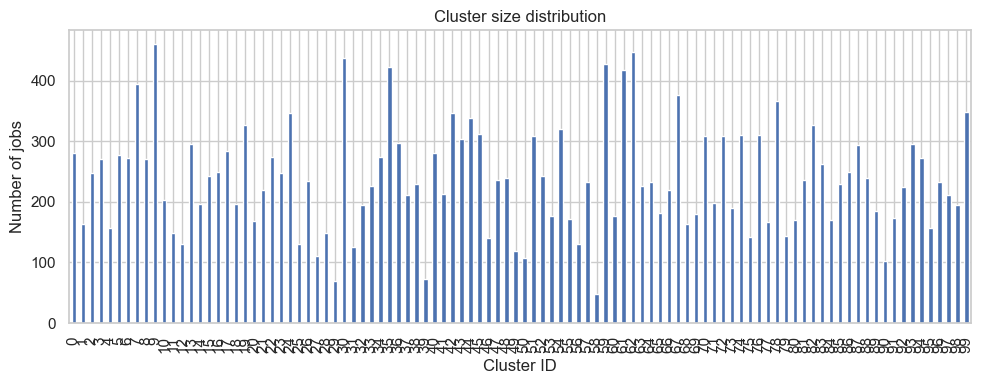

{'silhouette': 0.025465577840805054, 'davies_bouldin': 4.517230154820744, 'n_clusters': 100}
✅ Saved jobs_with_labels to: C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\jobs_boiler_v1_len50_cap3000.parquet


cluster  speciality          
0        Consulting              9
         IT Consulting           9
         IT Staffing             4
1        Packaging               3
         packaging               3
                                ..
98       Life Insurance          8
         Auto Insurance          5
99       IT Staffing             7
         Software Development    7
         IT Consulting           5
Name: count, Length: 300, dtype: int64

,company_id,speciality,name,description
6,1038,Audit,Deloitte,Deloitte drives progress. Our firms around the...
56,1353,IT Services,Tata Consultancy Services,"Tata Consultancy Services is an IT services, c..."
73,1415,Business consulting,CGI,"Insights you can act on Founded in 1976, CGI i..."
147,1784,Consumer insight,Boston Consulting Group (BCG),Boston Consulting Group partners with leaders ...
309,2730,Digital Marketing,RR Donnelley,"RRD is a leading global provider of marketing,..."
511,3741,Executive Search,Korn Ferry,Korn Ferry. Business Advisors. Career Makers. ...
731,4972,Software & Platform Engineering,EPAM Systems,experience consulting partner for global enter...
780,5210,Advanced Analytics,L.E.K. Consulting,L.E.K. Consulting is a global management consu...
834,5509,Corporate Finance & Restructuring,FTI Consulting,"FTI Consulting, Inc. is a global business advi..."
873,5742,Aviation,ICF,ICF is a global consulting and technology serv...


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ KMeans에는 noise(-1) 없음
print("Number of clusters:", int(len(set(km_labels))))

# ✅ labels 붙일 때는 반드시 jobs_clean 사용 (embeddings와 row 맞추기)
jobs_with_labels = jobs_clean.copy()
jobs_with_labels["cluster"] = km_labels

# Top-3 speciality per cluster
if "speciality" in jobs_with_labels.columns:
    jobs_with_labels["speciality_clean"] = jobs_with_labels["speciality"].fillna("Unknown")
    top3 = (
        jobs_with_labels
        .groupby("cluster")["speciality_clean"]
        .value_counts()
        .groupby(level=0)
        .head(3)
    )
    display(top3)

# Cluster size distribution
cluster_sizes = pd.Series(km_labels).value_counts().sort_index()
display(cluster_sizes.head(10))

plt.figure(figsize=(10, 4))
cluster_sizes.plot(kind="bar")
plt.title("Cluster size distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of jobs")
plt.tight_layout()
plt.show()

# Internal metrics (여전히 낮을 수 있음. 텍스트는 흔함)
metrics = internal_cluster_metrics(embeddings, km_labels)
print(metrics)

# ✅ 저장: 네가 정해둔 JOBS_PATH로 저장 (버전명 포함된 파일)
jobs_with_labels.to_parquet(JOBS_PATH, index=False)
print("✅ Saved jobs_with_labels to:", JOBS_PATH)

# Look at a few clusters and their most common job titles
if "speciality" in jobs_with_labels.columns:
    display(
        jobs_with_labels.groupby("cluster")["speciality"]
        .value_counts()
        .groupby(level=0)
        .head(3)
    )

# Inspect one cluster
cluster_id = 0
cluster_sample = jobs_with_labels[jobs_with_labels["cluster"] == cluster_id].head(10)

id_col = cfg["jobs"]["id_column"] if "jobs" in cfg and "id_column" in cfg["jobs"] else None
cols = [c for c in [id_col, "speciality", "name", TEXT_COL] if c and c in cluster_sample.columns]

display(cluster_sample[cols] if cols else cluster_sample.head(10))
